In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
def norm_trace(seis):
    data_out = np.zeros(np.shape(seis))
    for k in range(np.size(seis,axis=1)):
        data_out[:,k] = seis[:,k]/np.max(np.abs(seis[:,k]))
    seis=data_out
    return seis
def envelope(xr):
    for i in range(np.size(xr,axis=1)):
        hx = fftpack.hilbert(xr[:,i])
        xr[:,i] = np.sqrt(np.power(xr[:,i],2) + np.power(hx,2))
    return xr
def imagesc(damp,alpha=1):
    fig = plt.figure()
    plt.pcolormesh(damp, vmin=np.min(damp)*alpha, vmax=np.max(damp)*alpha,cmap= 'jet')
    ax = plt.gca() 
    ax.invert_yaxis() 
    plt.colorbar()
    matplotlib.cm.get_cmap('jet')
def extend_wave(s,nt):
    ng = np.size(s,axis=1)
    if np.size(s[:,0])<nt:
        ss=np.zeros((nt,ng))
        for i in range(ng):
            xr=np.zeros((nt))
            xr[0:np.size(s[:,0])]=s[:,i]
            ss[:,i]=xr
    return ss
def pad(p0, nbc, pad_top):
    p=torch.cat((p0[:,0].reshape(-1,1).repeat(1,nbc),p0,p0[:,-1].reshape(-1,1).repeat(1,nbc)),dim=1)
    p=torch.cat((p[0,:].reshape(1,-1).repeat(pad_top,1),p,p[-1,:].reshape(1,-1).repeat(nbc,1)),dim=0)
    return p

In [2]:
import torch
#import visdom
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn, optim

import scipy.io as sio

class NN(nn.Module):
    def __init__(self, num_input, w0, h0, vmax, vmin):
        super(NN, self).__init__()
        self.net1 = nn.Sequential(
            nn.Linear(num_input, w0*h0*8,bias=False),        
            nn.ReLU(),
        )
    
        self.net2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(8, 128, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128, 64, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(64, 32, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(32, 16, (4, 4), stride=(1, 1), padding="same", bias=False),
            nn.LeakyReLU(negative_slope=0.01),
            
#             nn.UpsamplingBilinear2d(scale_factor=2),
#             nn.Conv2d(16, 8, (4, 4), stride=(1, 1), padding="same", bias=False),
#             nn.LeakyReLU(negative_slope=0.01),
            
            nn.Conv2d(16, 1, (4, 4), stride=(1, 1), padding="same", bias=False),
            
        )
    def forward(self, x):
        
        x = self.net1(x)
        x = x.reshape(-1, int(num_input), int(w0), int(h0))
        x = self.net2(x)
        return x


In [3]:
import torch.nn.functional as F
def staggeredfd_py_cuda(
    inputs,
    temp,
    ca,       
    cl,       
    cm,       
    cm1,        
    b,      
    b1,      
    s):
    nt = int(inputs[0])
    nzbc = int(inputs[1])
    nxbc = int(inputs[2])
    dtx = float(inputs[3])
    ng = int(inputs[4])
    sz = int(inputs[5]);sz = sz - 1;
    sx = int(inputs[6]);sx = sx - 1;
    gz = int(inputs[7]);gz = gz - 1;
    gx = int(inputs[8]);gx = gx - 1;
    dg = int(inputs[9])
    source_type_num = int(inputs[10])
    fd_order_num = int(inputs[11])
    number_elements = nt*ng
    length_geophone = ng*dg
    nt_interval = int(inputs[12])
    nz = int(inputs[13])
    nx = int(inputs[14])
    format_num = int(inputs[15])
    nbc = (nxbc-nx)/2
    num_nt_record = nt//nt_interval
    wavefield_elements = num_nt_record*nx*nz


    #   Input variables from python numpy: temp ca cl cm b s
    # libtorch Initialising input variables: uu, ww, xx, xz, zz
    uu = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    ww = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    xx = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    xz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    zz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    #  libtorch Initialising input variables: fux, fuz, bwx, bwz
    fux = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    fuz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    bwx = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    bwz = torch.zeros((nzbc,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    #  libtorch Initialising output variables: seismo_w, seismo_u       
    seismo_w = torch.zeros((nt,ng), dtype=torch.float32, device=torch.device('cuda', 0))
    seismo_u = torch.zeros((nt,ng), dtype=torch.float32, device=torch.device('cuda', 0))

    wavefield_gradient_fux = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))
    wavefield_gradient_fuz = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))
    wavefield_gradient_bwx = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))
    wavefield_gradient_bwz = torch.zeros((nz,nx*num_nt_record), dtype=torch.float32, device=torch.device('cuda', 0))

    #  libtorch zero_vector for free surface zz
    zero_vector = torch.zeros((1,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))
    geophone_vector = torch.zeros((1,nxbc), dtype=torch.float32, device=torch.device('cuda', 0))

    if fd_order_num==22 :
        k = nzbc-2; i = nxbc-2; pad_top = 1;
    elif fd_order_num==24 :
        k = nzbc-4; i = nxbc-4; pad_top = 2;
    elif fd_order_num==26 :
        k = nzbc-6; i = nxbc-6; pad_top = 3;
    elif fd_order_num==28 :
        k = nzbc-8; i = nxbc-8; pad_top = 4;
    S41 = 1.1250;S42 = -0.0416666667;S61 = 1.17187;S62 = -6.51042E-2;S63 = 4.68750E-3;S81 = 1.19629;S82 = -7.97526E-2;S83 = 9.57031E-3;S84 = -6.97545E-4;

    for it in range(nt) :
        if  fd_order_num == 22 :
            uu = F.pad((temp[1:1+k, 1:1+i]*(uu[1:1+k, 1:1+i]) + b[1:1+k, 1:1+i]*(  \
                    xx[1:1+k, 1+1:1+1+i] - xx[1:1+k, 1:1+i] + xz[1:1+k, 1:1+i] - xz[1-1:1-1+k, 1:1+i])), [1, 1, 1, 1])   
            ww = F.pad((temp[1:1+k, 1:1+i]*(ww[1:1+k, 1:1+i]) + b1[1:1+k, 1:1+i]*(  \
                    xz[1:1+k, 1:1+i] - xz[1:1+k, 1-1:1-1+i] + zz[1+1:1+1+k, 1:1+i] - zz[1:1+k, 1:1+i])), [1, 1, 1, 1])         
        
        if source_type_num == 5:
            ww[sz,sx]=s[it]
        
        if fd_order_num == 22 :
            fux = F.pad((uu[1:1+k, 1:1+i] - uu[1:1+k, 1-1:1-1+i]), [1, 1, 1, 1])   
            fuz = F.pad((uu[1+1:1+1+k, 1:1+i] - uu[1:1+k, 1:1+i]), [1, 1, 1, 1])   
            bwx = F.pad((ww[1:1+k, 1+1:1+1+i] - ww[1:1+k, 1:1+i]), [1, 1, 1, 1])   
            bwz = F.pad((ww[1:1+k, 1:1+i] - ww[1-1:1-1+k, 1:1+i]), [1, 1, 1, 1])   
            
        xx=temp * (xx) + (ca * (fux) + cl * (bwz))*dtx
        zz=temp * (zz) + (ca * (bwz) + cl * (fux))*dtx
        xz=temp * (xz) + (cm1 * (fuz + bwx))*dtx

#         zz[pad_top,:]=0.0

        seismo_w[it, :] = ww[gz,gx:gx+length_geophone-1:2]

        seismo_u[it, :] = uu[gz,gx:gx+length_geophone-1:2]
#         if(it%nt_interval==0):
#             wavefield_gradient_fux[:, nx*it//nt_interval:nx*it//nt_interval + nx]=fux[pad_top+1:pad_top+1+nz, nbc:nbc + nx]
#             wavefield_gradient_fuz[:, nx*it//nt_interval:nx*it//nt_interval + nx]=fuz[pad_top+1:pad_top+1+nz, nbc:nbc + nx]
#             wavefield_gradient_bwx[:, nx*it//nt_interval:nx*it//nt_interval + nx]=bwx[pad_top+1:pad_top+1+nz, nbc:nbc + nx]
#             wavefield_gradient_bwz[:, nx*it//nt_interval:nx*it//nt_interval + nx]=bwz[pad_top+1:pad_top+1+nz, nbc:nbc + nx]  


    return seismo_u,seismo_w

In [4]:
import numpy as np
import scipy.io as sio
dummy_input = sio.loadmat('dummy_input.mat')
for dummy_input_key in list(dummy_input.keys())[3:]:
    print(dummy_input_key)
    exec(dummy_input_key + '=dummy_input["' + dummy_input_key + '"].astype(np.float32)')
    exec(dummy_input_key + '=torch.from_numpy(' + dummy_input_key + ').to("cuda")')
#     exec(dummy_input_key + '=torch.from_numpy(' + dummy_input_key + ')')
tempmat = sio.loadmat('tempmat.mat')
temp = tempmat['temp'].astype(np.float32)
temp = torch.from_numpy(temp)
# geo_l = np.array([range(40,159,2)]).astype(np.float32)
# input_vector = input_vector.reshape(-1, 1)
# geo_l = torch.from_numpy(geo_l.reshape(-1, 1)).to("cuda")
# import sys
# sys.path.append('/home/user/.vscode/eigen_staggerfd_2py/')
# import eigen_staggerfd_2py
# [uu,ww]=eigen_staggerfd_2py.staggeredfd(input_vector,temp,ca,cl,cm,cm1,b,b1,s,geo_l)
# input_vector: [nt,nzbc,nxbc,dtx,ng,sz,sx,gz(1),gx(1),gx(2)-gx(1),source_type_num,fd_order_num,in_wf,nz,nx,format_num];
# [uu,ww]=staggerfd.forward(input_vector,temp,ca,cl,cm,cm1,b,b1,s)
# for gg in range(1,60,8):
#     input_vector[6] = geo_l[gg]
#     [uu,wwt]=staggerfd.forward(input_vector,temp,ca,cl,cm,cm1,b,b1,s)
#     print(gg)
#     exec('wwt' + str(gg) + '=wwt')

s
ca
cm
cl
temp
cm1
b
b1
input_vector
vs


In [5]:
import torch
import staggerfd
import staggerfd_cuda
import staggerfd_cuda1

In [6]:
#参数设置
# model1=torch.zeros([26,120])
# model1[0:12,:]=1000
# model1[12:26,:]=2500    #普通测试模型
model_list = sio.loadmat('low_vel.mat')
vp_RM = torch.from_numpy(model_list['vp'].astype('float32'))
vs_RM = torch.from_numpy(model_list['vs'].astype('float32'))
# vp_RM = model1
[nz,nx]=vp_RM.shape  #nz：深度网格点数，nx测线方向网格点数
nbc=40                  #吸收边界长
dx=1                    #一网格点对应深度
dt=dx/torch.max(vp_RM)*0.5  #公式
# nt=torch.floor(nx*dx/torch.min(vp_RM)/dt+300) #公式，不能过短
nt=1100

#ricker
#[s,~]=ricker(fr,dt,nt)
fr=30              #频率
# nw=2.2/fr/dt         #2.2？？？
# nw=2*torch.floor(nw/2)+1
# nc=torch.floor(nw/2)
# k=torch.arange(1,nw,1)
# alpha = (nc-k+1)*fr*dt*torch.pi
# beta=alpha**2
# w0 = (1.-beta**2)*torch.exp(-beta)  #ricker子波
# s=torch.zeros((nt))
# s[0:w0.numel()]=w0
########
pad_top = 2
nbc = 40
ds=8
sx=torch.arange(0,nx,ds)
sz=torch.zeros(sx.shape)+1      #炮点位置
ns=sx.numel()
dg=2
gx=torch.arange(0,nx,dg)
ng=gx.numel()
gz=torch.zeros(gx.shape)+1
isFS=1
sx=sx+nbc
sz=sz+pad_top-1
gx=gx+nbc
gz=gz+pad_top-1
seismo_v_d=torch.zeros((ns,nt,ng)).to('cuda')


In [7]:
x = torch.rand(size=(1, 8)).requires_grad_(True)
vmax=torch.max(vp_RM)
vmin=torch.min(vp_RM)
[nz,nx] = vp_RM.shape
asd = torch.linspace(vmin,vmax,nz).view(-1,1)
vp0 = asd.repeat(1,nx)
vs0 = vs_RM
num_layer=4
num_input = 8
w0=int(np.ceil(vp0.shape[0]/(2**num_layer)))
h0=int(np.ceil(vp0.shape[1]/(2**num_layer)))
torch.set_printoptions(precision=10)
maxline = vmax*torch.ones_like(vp0)
minline = vmin*torch.ones_like(vp0)

In [8]:

dtx = 0.0002
den = pad(torch.ones((nz,nx)),nbc,pad_top)
vp1 = pad(vp0,nbc,pad_top)
vs0 = pad(vs0,nbc,pad_top)
ca=torch.mul(vp1**2,den)
cm=torch.mul((vs0**2),den)
cl=ca - 2*cm
# temp = pad(temp,nbc,pad_top)

den[0:pad_top,:] = 0.5*den[0:pad_top,:]
den1=den
den1[pad_top-1,:]=2*den1[pad_top-1,:]
cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
cm1=cm;
cl[0:pad_top-1,:]=0.0;
cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
ca=cl + 2*cm
b=dtx*torch.reciprocal(den)
b1=dtx*torch.reciprocal(den1)
nzbc = nz + nbc + pad_top
nxbc = nx + nbc + nbc
source_type_num = 5
fd_order_num = 22
in_wf = 1
format_num = 2
# input_vector: [nt,nzbc,nxbc,dtx,ng,sz,sx,gz(1),gx(1),gx(2)-gx(1),source_type_num,fd_order_num,in_wf,nz,nx,format_num];


In [9]:
input_vector = torch.tensor([nt,nzbc,nxbc,dtx,ng,int(sz[0]),int(sx[0]),int(gz[0]),int(gx[0]),int(gx[1]-gx[0]), \
                             source_type_num,fd_order_num,in_wf,nz,nx,format_num])

In [10]:
nx

180

In [11]:
model = NN(8, w0, h0, vmax, vmin)

In [12]:
for le in ['vp_RM','s','sx','sz','gx','gz','x','vp0 ','maxline','minline','vs0','den','input_vector','temp']:
    print(le)
    exec(le + '=' + le + '.to("cuda:0")')
model.to("cuda:0")

vp_RM
s
sx
sz
gx
gz
x
vp0 
maxline
minline
vs0
den
input_vector
temp


NN(
  (net1): Sequential(
    (0): Linear(in_features=8, out_features=288, bias=False)
    (1): ReLU()
  )
  (net2): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(8, 128, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (4): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (7): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (10): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(16, 1, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
  )
)

In [13]:
vp1 = pad(vp_RM,nbc,pad_top)
ca=torch.mul(vp1**2,den)
cm=torch.mul((vs0**2),den)
cl=ca - 2*cm
den[0:pad_top,:] = 0.5*den[0:pad_top,:]
den1=den
den1[pad_top-1,:]=2*den1[pad_top-1,:]
cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
cm1=cm;
cl[0:pad_top-1,:]=0.0;
cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
ca=cl + 2*cm
b=dtx*torch.reciprocal(den)
b1=dtx*torch.reciprocal(den1)
input_vector[6] = (sx[0])
[seismo_u,seismo_w]=staggeredfd_py_cuda(input_vector,temp,ca,cl,cm,cm1,b,b1,s)
# [seismo_u,seismo_w]=staggerfd_cuda1.forward(input_vector,temp,ca,cl,cm,cm1,b,b1,s)

In [14]:
seismo_w._version


1100

In [15]:
for i in range(ns):
#% display(['Synthetic data, shot is=',num2str(is),' ns=',num2str(ns)]);

        vp1 = pad(vp_RM,nbc,pad_top)
        ca=torch.mul(vp1**2,den)
        cm=torch.mul((vs0**2),den)
        cl=ca - 2*cm
        den[0:pad_top,:] = 0.5*den[0:pad_top,:]
        den1=den
        den1[pad_top-1,:]=2*den1[pad_top-1,:]
        cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
        cm1=cm;
        cl[0:pad_top-1,:]=0.0;
        cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
        ca=cl + 2*cm
        b=dtx*torch.reciprocal(den)
        b1=dtx*torch.reciprocal(den1)
        input_vector[6] = (sx[i])
        print(i)
        [uu,seismo_v_d[i,:,:]]=staggeredfd_py_cuda(input_vector,temp,ca,cl,cm,cm1,b,b1,s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [16]:
seismo_v_d.device

device(type='cuda', index=0)

In [17]:
vvmax = vmax-vmin
vvmin = vmin-vmax
((vvmax - vvmin) * np.array([-1,1]) + (vvmax + vvmin))/2.0

tensor([-798.2498168945,  798.2498168945], dtype=torch.float64)

In [18]:
import math
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv2d') != -1:
#         fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
#         bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
#         torch.nn.init.kaiming_uniform_(m.weight.data,a=math.sqrt(50))
        torch.nn.init.xavier_normal_(m.weight.data)
#         torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
#         fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
#         bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
#         torch.nn.init.kaiming_uniform_(m.weight.data,a=math.sqrt(50))
#         torch.nn.init.uniform_(m.bias.data, -bound, bound)
        torch.nn.init.xavier_normal_(m.weight.data)
model.apply(weights_init)

NN(
  (net1): Sequential(
    (0): Linear(in_features=8, out_features=288, bias=False)
    (1): ReLU()
  )
  (net2): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(8, 128, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (4): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (7): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (10): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(16, 1, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
  )
)

In [19]:
criteon = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
# optimizer = optim.Adagrad(model.parameters())

In [20]:
pretrained_weights = torch.load('./my_model_low.pth')
model.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [21]:
torch.autograd.set_detect_anomaly(True)

In [22]:
minline

tensor([[834.4359741211, 834.4359741211, 834.4359741211,  ...,
         834.4359741211, 834.4359741211, 834.4359741211],
        [834.4359741211, 834.4359741211, 834.4359741211,  ...,
         834.4359741211, 834.4359741211, 834.4359741211],
        [834.4359741211, 834.4359741211, 834.4359741211,  ...,
         834.4359741211, 834.4359741211, 834.4359741211],
        ...,
        [834.4359741211, 834.4359741211, 834.4359741211,  ...,
         834.4359741211, 834.4359741211, 834.4359741211],
        [834.4359741211, 834.4359741211, 834.4359741211,  ...,
         834.4359741211, 834.4359741211, 834.4359741211],
        [834.4359741211, 834.4359741211, 834.4359741211,  ...,
         834.4359741211, 834.4359741211, 834.4359741211]], device='cuda:0')

/home/user/anaconda3/lib/python3.8/site-packages/torch/nn/modules/conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(7.2385466865e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
step


[W python_anomaly_mode.cpp:104] Warning: Error detected in torch::autograd::CopySlices. Traceback of forward call that caused the error:
  File "/home/user/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/user/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/user/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/user/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/user/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 667, in start
    self.io_loop.start()
  File "/home/user/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/user/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

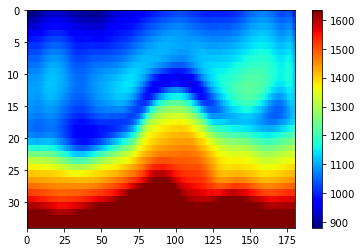

In [24]:
for i in range(10000):
    optimizer.zero_grad() 
    for gg in range(ns):
        
        
        y = model(x)
        y = ((vvmax - vvmin) * torch.tanh(y) + (vvmax + vvmin))/2.0
        y = torch.squeeze(y)
        y_shape0 = (y.shape[0] - vp0.shape[0])//2
        y_shape1 = (y.shape[1] - vp0.shape[1])//2
        velocity = vp0 + y[y_shape0:y_shape0+vp0.shape[0],y_shape1:y_shape1+vp0.shape[1]]
        velocity = torch.where(velocity > vmax, maxline, velocity)
        velocity = torch.where(velocity < vmin, minline, velocity)
        
        vp1 = pad(velocity,nbc,pad_top)
        ca=torch.mul(vp1**2,den)
        cm=torch.mul((vs0**2),den)
        cl=ca - 2*cm
#         den[0:pad_top,:] = 0.5*den[0:pad_top,:]
        den1=den
#         den1[pad_top-1,:]=2*den1[pad_top-1,:]
#         cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
        cm1=cm;
#         cl[0:pad_top-1,:]=0.0;
#         cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
        ca=cl + 2*cm
        b=dtx*torch.reciprocal(den)
        b1=dtx*torch.reciprocal(den1)
        input_vector[6] = int(sx[gg])
#         [uu,wwt]=staggeredfd_py_cuda(input_vector,temp,ca,cl,cm,cm1,b,b1,s)
        [seismo_u,seismo_w]=staggeredfd_py_cuda(input_vector,temp,ca,cl,cm,cm1,b,b1,s)
        loss = criteon(seismo_w.reshape(-1,1),seismo_v_d[gg,:,:].reshape(-1,1))
        loss.backward()
        print(loss)
    optimizer.step()
    print('step')
    if i%5==0:
        imagesc(velocity.detach().cpu().numpy())
#         plt.savefig('./model_low/iter' + str(j) + '.png')

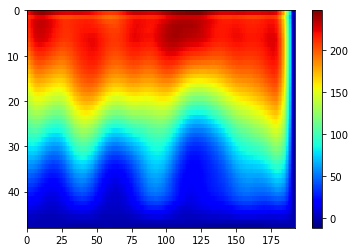

In [23]:
# j=0
imagesc(y.detach().cpu().numpy())
# plt.savefig('./model_low/iter' + str(j) + '.png')

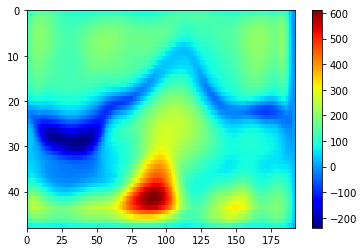

In [57]:
imagesc(y.detach().cpu().numpy())

In [63]:
import copy
model_low_model_wts = copy.deepcopy(model.state_dict())
PATH = "./my_model_low.pth"
torch.save(model_low_model_wts, PATH)

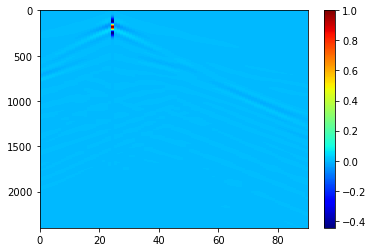

In [29]:
imagesc(seismo_w.detach().cpu().numpy())